In [61]:
from CAENpy.CAENDigitizer import CAEN_DT5740_Digitizer
import numpy as np
import matplotlib.pyplot as plt
import h5py, sys, os, pickle, time
sys.path.append("../../arduino_stages")
import stage_control as sc
sys.path.append("../InstekPPX10005")
import instekPPX10005 as vs

In [ ]:
instek = vs.open()
vs.set_output(instek, 'off')
vs.set_voltage(instek, 6.5)

AttributeError: module 'instekPPX10005' has no attribute 'set_volt'

In [60]:
## move stage (x,y in mm)
vs.set_output(instek, 'on')
sc.move_stage(-1,-1)
time.sleep(10)
vs.set_output(instek, 'off')

Moving by dX, dY: -1.0 mm, -1.0mm


NameError: name 'time' is not defined

In [3]:
digitizer = CAEN_DT5740_Digitizer(0) # Open the connection.

print(digitizer.idn) # Print general info about the digitizer.

CAEN DT5740D digitizer, serial number 31030


In [34]:
def configure_digitizer(digitizer, dc_offset_list, trig_level_list):

	enable_list = [True, True, True, False]  ## groups of 8 channels (1-8, 9-16, 17-24, 25-32)

	digitizer.set_record_length(128)
	digitizer.set_post_trigger_size(50) ## in percent
	digitizer.set_max_num_events_BLT(1023)
	digitizer.set_acquisition_mode('sw_controlled')
	digitizer.set_ext_trigger_input_mode('disabled')
	digitizer.enable_channels(enable_list)

	for i in range(4): ##loop over groups
		bloffset = int((1-dc_offset_list[i]) * 2**16)
		digitizer.set_group_DC_offset(i, DAC=bloffset)
		triglev = dc_offset_list[i]*2**12 + trig_level_list[i]
		digitizer.setup_trigger(i, int(triglev))
		digitizer.set_trigger_polarity(channel=i, edge='rising') 


Working on file 1 of 10
Reading 1023 events....


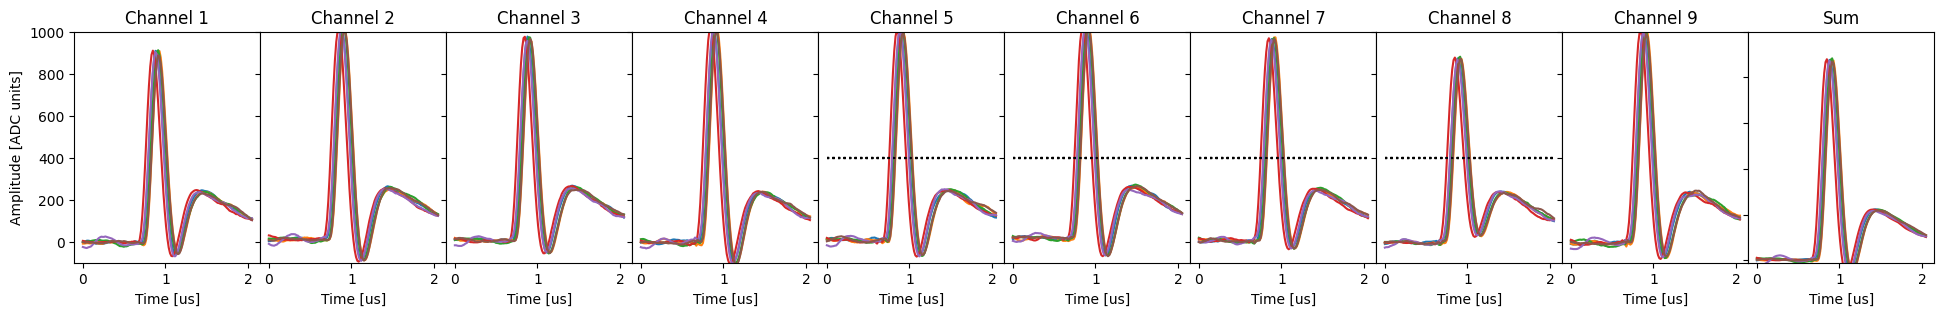

Working on file 2 of 10
Reading 1023 events....
Working on file 3 of 10
Reading 1023 events....
Working on file 4 of 10
Reading 1023 events....
Working on file 5 of 10
Reading 1023 events....
Working on file 6 of 10
Reading 1023 events....
Working on file 7 of 10
Reading 1023 events....
Working on file 8 of 10
Reading 1023 events....
Working on file 9 of 10
Reading 1023 events....
Working on file 10 of 10
Reading 1023 events....


In [46]:
Nfiles = 10
save_data = True
make_plot = True
path = "D:/data/SiPM/waveforms/20240503/"
file_name = "test_%d.pkl" #"Bi207_26V_x0_y0_%d.pkl"

dc_offset_list = [0.5, 0.5, 0.5, 0.5] ## list of dc offsets (fractional range 0-1)
										## e.g. if you want baseline at 25% of max ADC, set 0.25 here
trig_level_list = [2000, 400, 2000, 2000] ## list of trig levels in ADC counts above the baseline
										## e.g. if you 100 ADC counts above baseline, set 100 here

# Now configure the digitizer:
configure_digitizer(digitizer, dc_offset_list, trig_level_list)

# Now enter into acquisition mode using the `with` statement:

fsample = 62.5e6 ## sampling rate in Hz
record_length = 129 ## not clear why this differs from the 128 set above
time_vec = np.arange(0, record_length/fsample, 1/fsample)

for n in range(Nfiles):
	print("Working on file %d of %d"%(n+1, Nfiles))

	digitizer.start_acquisition(acq_time=1)
	waveforms = digitizer.get_waveforms()
	digitizer.stop_acquisition()

	if(save_data):
		if("%d" in file_name):
			fnameout = os.path.join(path, file_name%n)
		else:
			fnameout = os.path.join(path, file_name)
		with open(fnameout, 'wb') as fout:
			pickle.dump(waveforms, fout)

	if(make_plot and n == 0):
		plt.figure(figsize=(24,3))
		max_plot = 5
		step = int(len(waveforms)/max_plot)
		for wf in waveforms[::step]:
			sum_waveform = np.zeros_like(time_vec)	
			for j, ch in enumerate(range(16,-1,-2)):

				## subtract baseline
				baseline = 2048 #np.median(wf[ch][:20])

				plt.subplot(1,10,j+1)
				plt.plot(time_vec*1e6, wf[ch]-baseline)
				plt.ylim(-100, 1000)
				if(j > 0): 
					plt.gca().set_yticklabels([])
				else:
					plt.ylabel("Amplitude [ADC units]")
				plt.title("Channel %d"%(j+1))
				plt.xlabel("Time [us]")

				gidx = int(j/4)
				trig_lev = dc_offset_list[gidx]*2**12 + trig_level_list[gidx] - baseline
				plt.plot(time_vec*1e6, np.ones_like(time_vec)*trig_lev, 'k:')
				sum_waveform += (wf[ch] - baseline)

			plt.subplot(1,10,10)
			plt.plot(time_vec*1e6, sum_waveform)
			plt.ylim(-100, 10000)
			plt.gca().set_yticklabels([])
			plt.title("Sum")
			plt.xlabel("Time [us]")

		plt.subplots_adjust(wspace=0)
		plt.show()

In [37]:
print(len(wf[0]))

129
